In [1155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind
from scipy.stats import pearsonr


In [1156]:
# Load the dataset
df = pd.read_csv('London_Listings.csv')

# Original shape
print('Original Shape:', df.shape)

# First 5 rows
df.head()

Original Shape: (66679, 31)


,id,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,amenities,price,minimum_nights,maximum_nights,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,calculated_host_listings_count
0,2.763150e+07,1,NaN,35877912,Alex,15/06/2015,NaN,NaN,f,1.0,...,"[""Kitchen"", ""Refrigerator"", ""Microwave"", ""Free...",$200.00,1,1125,14/06/2024,0,NaN,NaN,NaN,1
1,1.100000e+18,1,Get comfortable and enjoy plenty of extra room...,564055882,Lili-Ann,26/02/2024,NaN,NaN,f,1.0,...,[],$675.00,1,365,15/06/2024,0,NaN,NaN,NaN,1
2,1.170000e+18,117,Keep it simple at this peaceful and centrally-...,528033284,Shujauddin,26/07/2023,86%,50%,f,2.0,...,"[""Washer"", ""Wifi"", ""Kitchen""]",$95.00,1,365,16/06/2024,0,NaN,NaN,NaN,2
3,8.730000e+17,- Bright Central London Apartment -,My apartment has everything you possibly need ...,99268099,Alex,11/10/2016,98%,93%,t,5.0,...,"[""Microwave"", ""Hot water kettle"", ""Body soap"",...",$166.00,7,365,16/06/2024,24,24/04/2023,02/05/2024,4.83,1
4,4.672403e+07,""" Bright & Cosy Loft apartment """,Lovely and cosy arctic space with a separate d...,359199241,Karol,29/07/2020,100%,95%,t,1.0,...,"[""Cleaning products"", ""Cooking basics"", ""First...",$105.00,2,60,14/06/2024,46,20/08/2021,02/06/2024,4.89,1


In [1157]:
# Check types before categorising
print(df.dtypes)

id                                float64
name                               object
description                        object
host_id                             int64
host_name                          object
host_since                         object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_listings_count               float64
host_total_listings_count         float64
neighbourhood                      object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                    

In [1158]:
# Organise the coluns in categorical and numerical types
categorical_var = df.select_dtypes(include=['object']).columns.tolist()
numerical_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Variables:", categorical_var)
print("Numerical Variables:", numerical_var)

Categorical Variables: ['name', 'description', 'host_name', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'calendar_last_scraped', 'first_review', 'last_review']
Numerical Variables: ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count']


In [1159]:
# Count unique rows with at least one missing value
unique_missing_rows_before = df.isnull().any(axis=1).sum()

# Calculate the percentage of the dataset that has missing values
total_rows = df.shape[0]
percentage_missing = (unique_missing_rows_before / total_rows) * 100

# Print results
print(f"Total unique rows with missing values: {unique_missing_rows_before}")
print(f"Percentage of dataset with missing values: {percentage_missing:.2f}%")

Total unique rows with missing values: 24805
Percentage of dataset with missing values: 37.20%


In [1160]:
# Fix the price column by removing $ sign and commas.
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Create a copy of the untouched dataset so we can compare to the data cleaning later.
df_first = df.copy()

# Remove listings with zero or negative prices
df = df[df['price'] > 0]
print(df['price'].describe())

# Drop rows where 'price' is NaN since it is a target variable. (Important one)
df.dropna(subset=['price'], inplace=True) # 61418
print("Shape after removing empty `price` rows:", df.shape)

# 3 properties of 80000.00, 1 propert of 1.00

count    61417.000000
mean       209.990621
std        961.458327
min          1.000000
25%         78.000000
50%        138.000000
75%        227.000000
max      80000.000000
Name: price, dtype: float64
Shape after removing empty `price` rows: (61417, 31)


In [1161]:
# Categorical variables, remove empty strings or lists and replace with Nan.
for col in categorical_var:
    df[col] = df[col].replace(['', '[]'], np.nan)
    
missing_col_val = df.isnull().sum()
print('Missing column values:\n', missing_col_val[missing_col_val > 0])

Missing column values:
 description                   1870
host_name                        1
host_since                       1
host_response_rate            6615
host_acceptance_rate          4365
host_is_superhost              370
host_listings_count              1
host_total_listings_count        1
bathrooms                       69
bathrooms_text                 100
bedrooms                       101
beds                           140
amenities                      132
first_review                 14736
last_review                  14736
review_scores_rating         14736
dtype: int64


In [1162]:
# Drop unnecessary columns, as they are either replaced or are useless in the model building.
drop_columns = ['host_name', 'calendar_last_scraped', 'bathrooms_text', 'latitude', 'longitude', 'first_review', 'last_review', 'id' ]
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Updated shape
print("Shape after dropping unnecessary columns:", df.shape)

Shape after dropping unnecessary columns: (61417, 23)


In [1163]:
# Fill missing values with median as it's the safest and least aggresive approach of thinning our dataset size
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)

# Updated shape
print('Shape after dropping duplicates and NaN rows:', df.shape)

Shape after dropping duplicates and NaN rows: (61417, 23)


In [1164]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 52


In [1165]:
# Drop duplicate rows since the number of duplicates is low compared to our dataset size
df.drop_duplicates(inplace=True)
# Check the new shape
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (61365, 23)


In [1166]:
# Count rows where number_of_reviews is 0 and review_scores_rating is NaN
zero_reviews_missing_rating = df[(df['number_of_reviews'] == 0) & (df['review_scores_rating'].isnull())]

print(f"Listings with 0 reviews and missing rating: {zero_reviews_missing_rating.shape[0]}")
print(f"Total missing review_scores_rating: {df['review_scores_rating'].isnull().sum()}")


Listings with 0 reviews and missing rating: 14685
Total missing review_scores_rating: 14685


In [1167]:
# Fill missing review scores with 0 (indicating that there have no reviews)
df.loc[df['number_of_reviews'] == 0, 'review_scores_rating'] = 0

# Check if missing values remain
print("Missing values after fixing review_scores_rating:", df['review_scores_rating'].isnull().sum())

Missing values after fixing review_scores_rating: 0


In [1168]:
# Fill missing columns
df['amenities'].fillna("Unknown", inplace=True)
df['description'].fillna("No description", inplace=True)

# Convert response & acceptance rate to numeric by removing % and diving by 100
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float) / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

# Fill missing values with median
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median(), inplace=True)

# Convert 'host_is_superhost' to binary (t → 1, f → 0)
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['host_is_superhost'].fillna(0, inplace=True)  # Assuming that missing → not superhost

# Check if missing values remain
print("Missing values after handling host columns:\n", df.isnull().sum()[df.isnull().sum() > 0])

Missing values after handling host columns:
 host_since                   1
host_listings_count          1
host_total_listings_count    1
dtype: int64


In [1169]:
# Drop rows where values of the subset are missing, since it's only 3 in the dataset this is an insignificant loss. Not likely to scew the data.
df.dropna(subset=['host_since', 'host_listings_count', 'host_total_listings_count'], inplace=True)
print("Missing values after dropping specific rows:\n", df.isnull().sum()[df.isnull().sum() > 0])


Missing values after dropping specific rows:
 Series([], dtype: int64)


In [1170]:
# Let's check the shape of the dataset after all this cleaning.
print("Shape after cleaning:", df.shape)


Shape after cleaning: (61364, 23)


In [1171]:
# Keep a copy of categorical columns for visualization
df['neighbourhood_original'] = df['neighbourhood']
df['property_type_original'] = df['property_type']
df['original_room_type'] = df['room_type']

# One-Hot Encode categorical variables (new columns)
df = pd.get_dummies(df, columns=['neighbourhood', 'property_type', 'room_type'])

# Check updated shape
print("Shape after encoding with preserved original columns:", df.shape)
print(df.columns)

Shape after encoding with preserved original columns: (61364, 145)
Index(['name', 'description', 'host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'accommodates',
       ...
       'property_type_Shared room in villa', 'property_type_Shepherd’s hut',
       'property_type_Shipping container', 'property_type_Tent',
       'property_type_Tiny home', 'property_type_Tower',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=145)


In [1172]:
# Convert room types columns to numeric (0/1) only if needed (My partner had issues that get_dummies converted to T/F instead of 1/0)
for col in df.columns:
    if col.startswith('room_type_'):
        unique_vals = set(df[col].dropna().unique())
        if unique_vals.issubset({0, 1}):
            continue  # If its already 1/0
        # Otherwise, convert if boolean or string True/False
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        else:
            df[col] = df[col].map({'False': 0, 'True': 1})


In [1173]:
# Winsorization (instead of removing outliers traditional way, this caps the values at the 99th percentile)
df_before_winsor = df.copy()

df['price'] = winsorize(df['price'], limits=[0.01, 0.01])
df['accommodates'] = winsorize(df['accommodates'], limits=[0.01, 0.01])
df['bedrooms'] = winsorize(df['bedrooms'], limits=[0.01, 0.01])
df['beds'] = winsorize(df['beds'], limits=[0.01, 0.01])
df['bathrooms'] = winsorize(df['bathrooms'], limits=[0.01, 0.01])


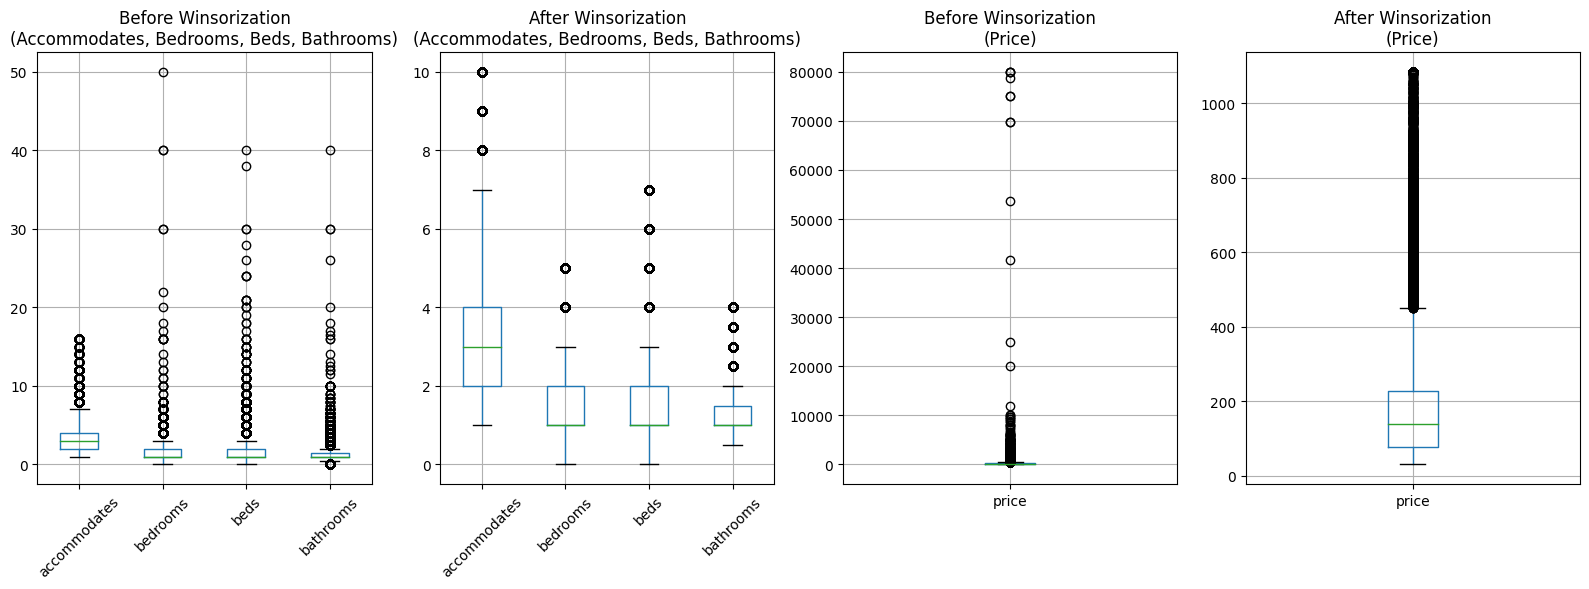

In [1174]:
# Columns to check
outlier_cols = ['accommodates', 'bedrooms', 'beds', 'bathrooms']

fig, axes = plt.subplots(1, 4, figsize=(16, 6))

# Boxplot BEFORE Winsorization (Multiple Features)
df_before_winsor[outlier_cols].boxplot(ax=axes[0])
axes[0].set_title("Before Winsorization\n(Accommodates, Bedrooms, Beds, Bathrooms)")
axes[0].tick_params(axis='x', rotation=45)

# Boxplot AFTER Winsorization (Multiple Features)
df[outlier_cols].boxplot(ax=axes[1])
axes[1].set_title("After Winsorization\n(Accommodates, Bedrooms, Beds, Bathrooms)")
axes[1].tick_params(axis='x', rotation=45)

# Boxplot BEFORE Winsorization (Price)
df_before_winsor[['price']].boxplot(ax=axes[2])
axes[2].set_title("Before Winsorization\n(Price)")
axes[2].tick_params(axis='x', rotation=0)

# Boxplot AFTER Winsorization (Price)
df[['price']].boxplot(ax=axes[3])
axes[3].set_title("After Winsorization\n(Price)")
axes[3].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [1175]:
#Convert price into logs for more event distribution where price is not scewed left-wards.

df['log_price'] = np.log(df['price'])
df[['price', 'log_price']].describe()

,price,log_price
count,61364.000000,61364.000000
mean,188.032544,4.925346
std,176.304053,0.769227
min,30.000000,3.401197
25%,78.000000,4.356709
50%,138.000000,4.927254
75%,227.000000,5.424950
max,1084.000000,6.988413


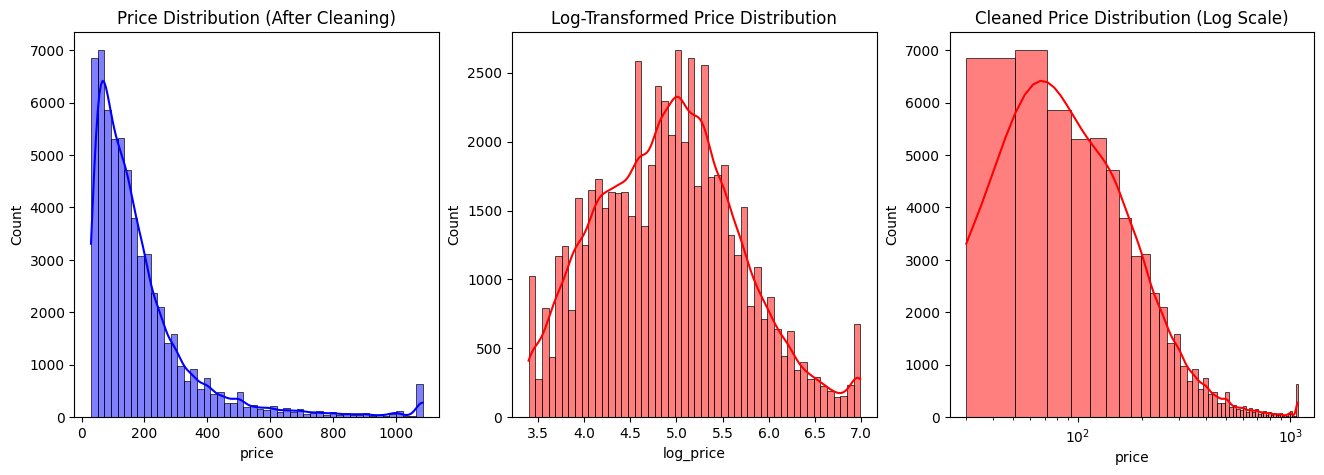

In [1176]:
plt.figure(figsize=(16, 5))

# Original price distribution
plt.subplot(1, 3, 1)
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Price Distribution (After Cleaning)")

# Log-transformed price distribution
plt.subplot(1, 3, 2)
sns.histplot(df['log_price'], bins=50, kde=True, color='red')
plt.title("Log-Transformed Price Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df['price'], bins=50, kde=True, color='red')
plt.xscale('log')
plt.title("Cleaned Price Distribution (Log Scale)")

plt.show()

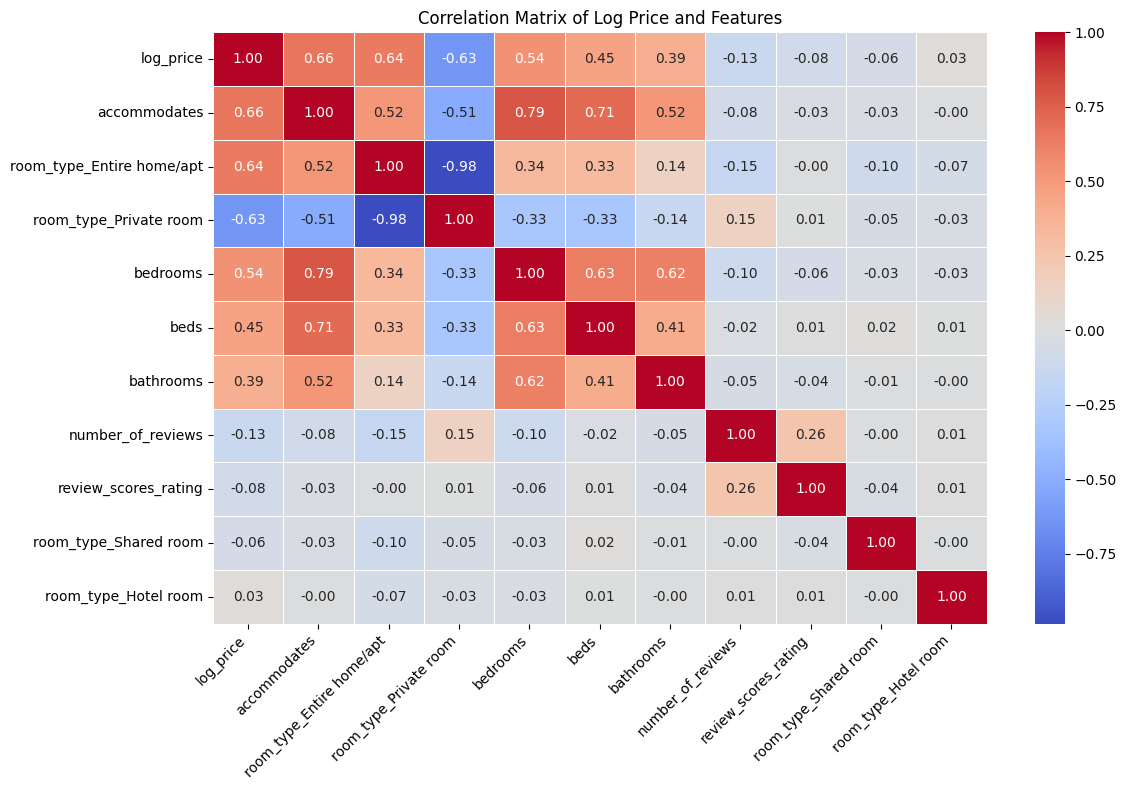

In [1177]:
# Compute correlation matrix including log_price
room_type_columns = [col for col in df.columns if col.startswith('room_type_')]
correlation_features = ['log_price', 'accommodates', 'bedrooms', 'beds', 
                        'bathrooms', 'number_of_reviews', 'review_scores_rating'] + room_type_columns

correlation_matrix = df[correlation_features].corr()

# Sort features in order of strength
log_price_correlations = correlation_matrix['log_price'].drop('log_price')
sorted_features = log_price_correlations.abs().sort_values(ascending=False).index.tolist()

# Reorder correlation matrix with log_price first, followed by sorted features
ordered_features = ['log_price'] + sorted_features
ordered_correlation_matrix = correlation_matrix.loc[ordered_features, ordered_features]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Log Price and Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1178]:
# Define numerical features to normalize
numerical_features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating']

# Create a copy before normalization (to compare later)
df_original = df.copy()

# Initialize scaler
scaler = StandardScaler()

# Apply StandardScaler and store in new columns with "_normalized" suffix
df[[col + "_normalized" for col in numerical_features]] = scaler.fit_transform(df[numerical_features])

# Check transformation results
print(df[[col + "_normalized" for col in numerical_features]].describe())


       accommodates_normalized  bedrooms_normalized  beds_normalized   
count             6.136400e+04         6.136400e+04     6.136400e+04  \
mean             -6.669588e-17        -2.501096e-17    -5.187458e-17   
std               1.000008e+00         1.000008e+00     1.000008e+00   
min              -1.181581e+00        -1.621351e+00    -1.170240e+00   
25%              -6.856435e-01        -5.563137e-01    -4.499515e-01   
50%              -1.897062e-01        -5.563137e-01    -4.499515e-01   
75%               3.062310e-01         5.087234e-01     2.703371e-01   
max               3.281854e+00         3.703835e+00     3.871780e+00   

       bathrooms_normalized  number_of_reviews_normalized   
count          6.136400e+04                  6.136400e+04  \
mean          -1.954560e-16                 -1.713714e-17   
std            1.000008e+00                  1.000008e+00   
min           -1.379073e+00                 -4.431696e-01   
25%           -5.735691e-01                 -4

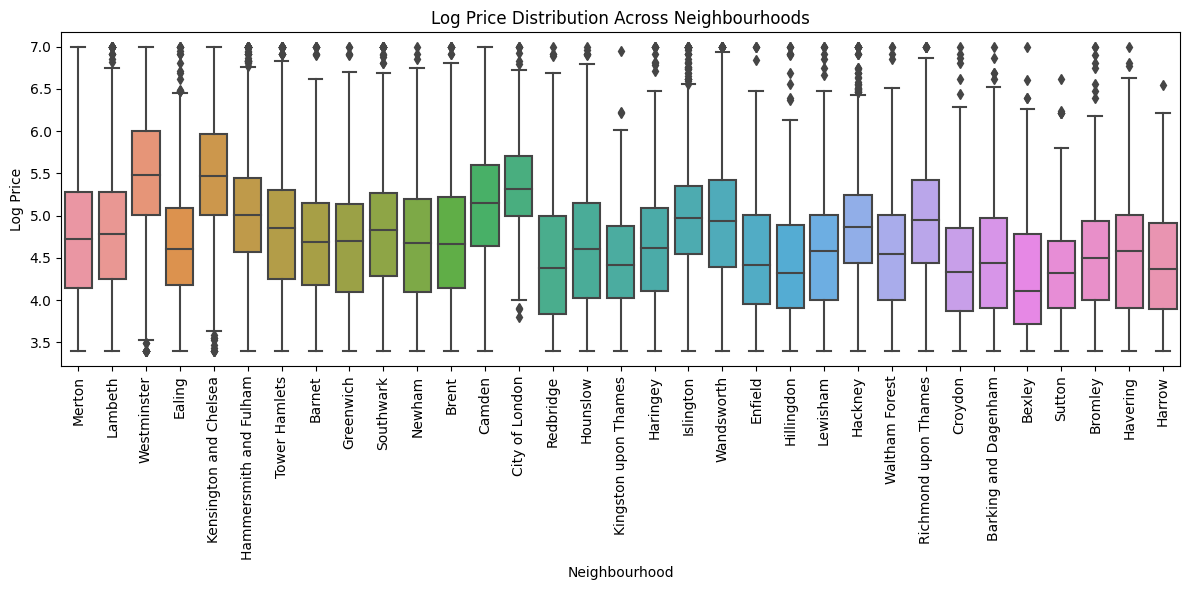

In [1179]:
# Visualization: Price Across Neighborhoods

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='neighbourhood_original', y='log_price')
plt.xticks(rotation=90)
plt.title('Log Price Distribution Across Neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

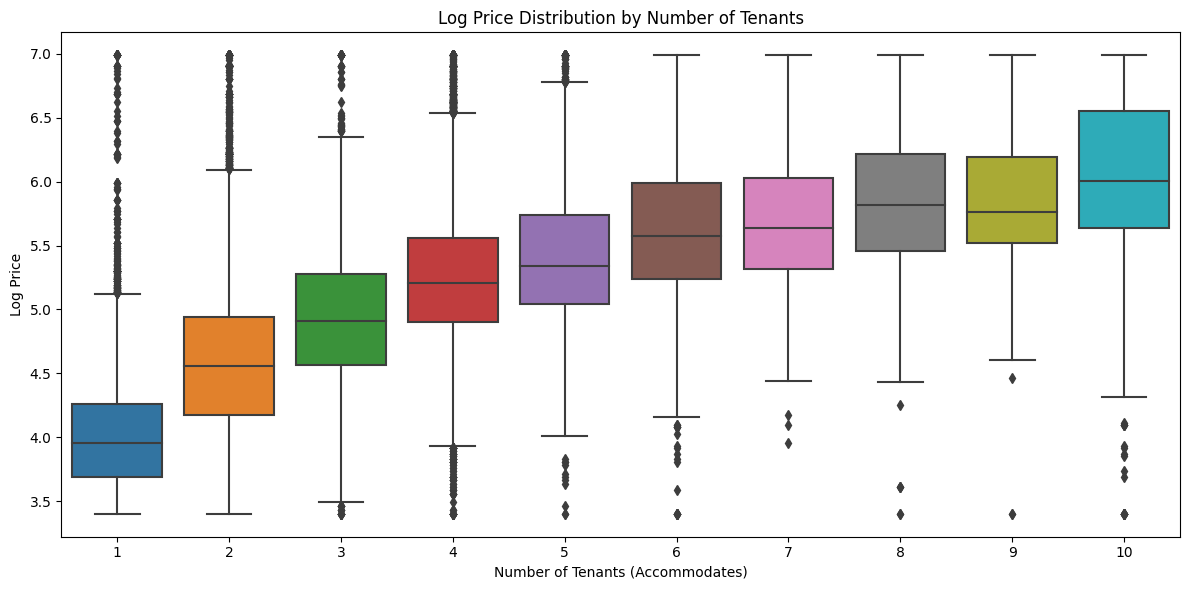

In [1180]:
# Visualization: Price by Number of Accommodates

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_original, x='accommodates', y='log_price')
plt.title('Log Price Distribution by Number of Tenants')
plt.xlabel('Number of Tenants (Accommodates)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

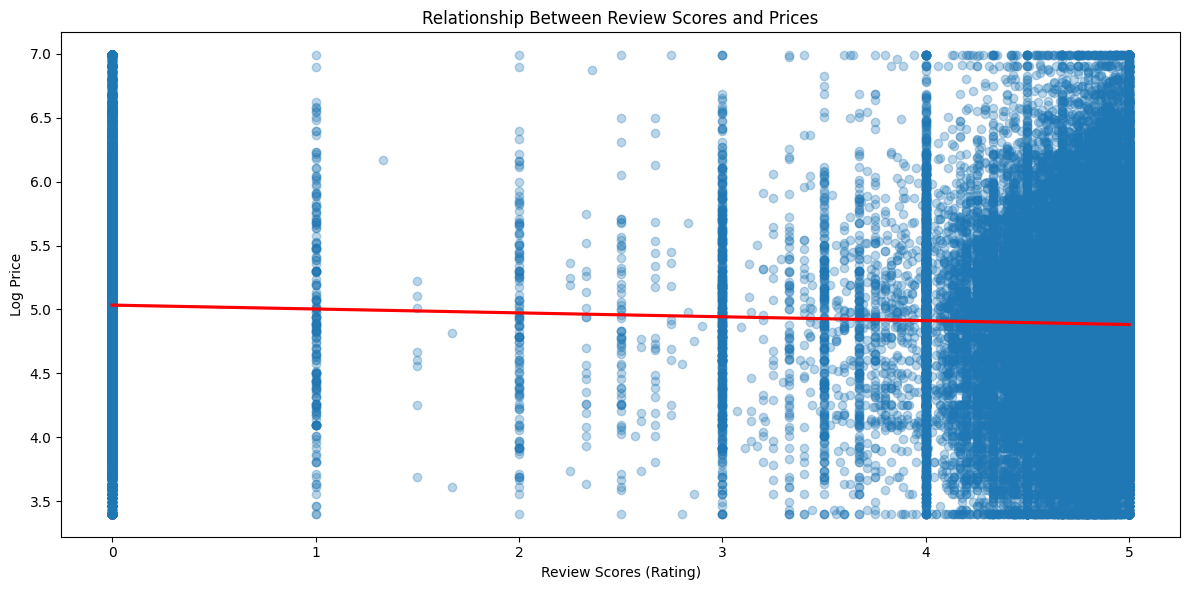

In [1181]:
# Visualization: Relationship Between Review Scores and Prices

plt.figure(figsize=(12, 6))
sns.regplot(
    data=df_original,
    x='review_scores_rating',
    y='log_price',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Review Scores and Prices')
plt.xlabel('Review Scores (Rating)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

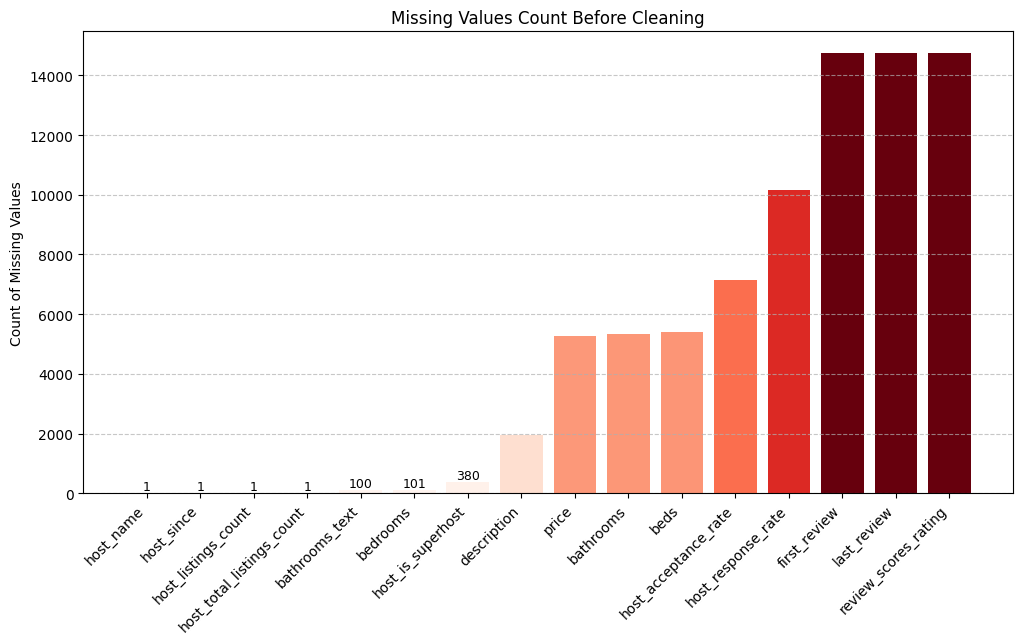

In [1182]:
# Sort missing values in ascending order
missing_values_before = df_first.isnull().sum()
missing_values_before = missing_values_before[missing_values_before > 0].sort_values()

# Create bar plot with enhancements
plt.figure(figsize=(12, 6))
bars = plt.bar(missing_values_before.index, missing_values_before, color=plt.cm.Reds(missing_values_before / missing_values_before.max()))

# Add labels for small values
for bar in bars:
    height = bar.get_height()
    if height < missing_values_before.max() * 0.1:  # Label only small values
        plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{int(height)}', ha='center', fontsize=9, color='black')

# Format the graph
plt.title("Missing Values Count Before Cleaning")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Create Linear Regression

In [1183]:
# converting both neighbourhood and room types
neighbourhood_columns = [col for col in df_cleaned.columns if col.startswith('neighbourhood_')]
room_type_columns = [col for col in df_cleaned.columns if col.startswith('room_type_')]


# Selected features being used for linear regression 
selected_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'review_scores_rating'
]   + room_type_columns + neighbourhood_columns


X = df[selected_features] # features chosen above
Y = df['log_price'] #  target

#Split into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training data Shape:", trainX.shape, trainY.shape)
print("Testing data Shape:", testX.shape, testY.shape)

#Training the linear regression model
model = LinearRegression()
model.fit(trainX, trainY)
predicted_log_prices = model.predict(testX)

# Evaluate performance
r2 = r2_score(testY, predicted_log_prices)
mse = mean_squared_error(testY, predicted_log_prices)
mae = mean_absolute_error(testY, predicted_log_prices)
r2_percentage = r2 * 100
mae_percentage = (mae / np.mean(testY)) * 100

# Printing results
print(f"\nModel Performance:")
print(f"R² Score: {r2:.4f} ({r2_percentage:.2f}%)") 
print(f"MSE: {mse:.4f}") 
print(f"MAE: {mae:.4f} ({mae_percentage:.2f}% of average log price)") 


Training data Shape: (49091, 42) (49091,)
Testing data Shape: (12273, 42) (12273,)

Model Performance:
R² Score: 0.6779 (67.79%)
MSE: 0.1931
MAE: 0.3294 (6.69% of average log price)


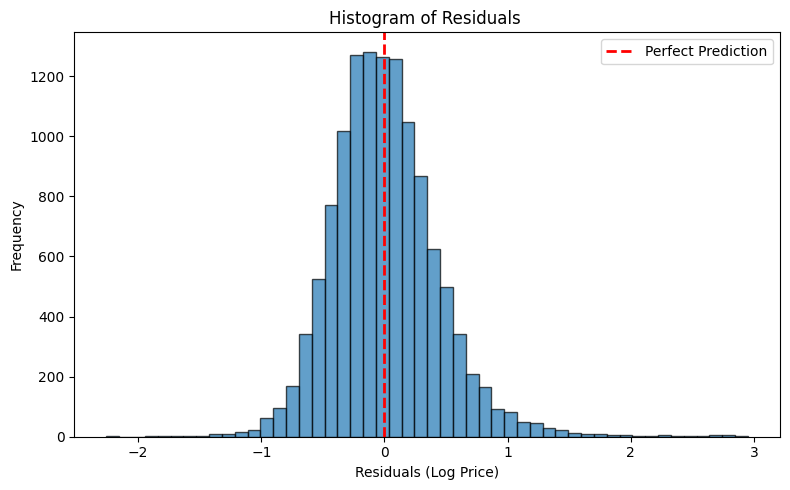

In [1184]:
# Compute residuals to see skew of under/over pricing
residuals = testY - predicted_log_prices

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (Log Price)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals ')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


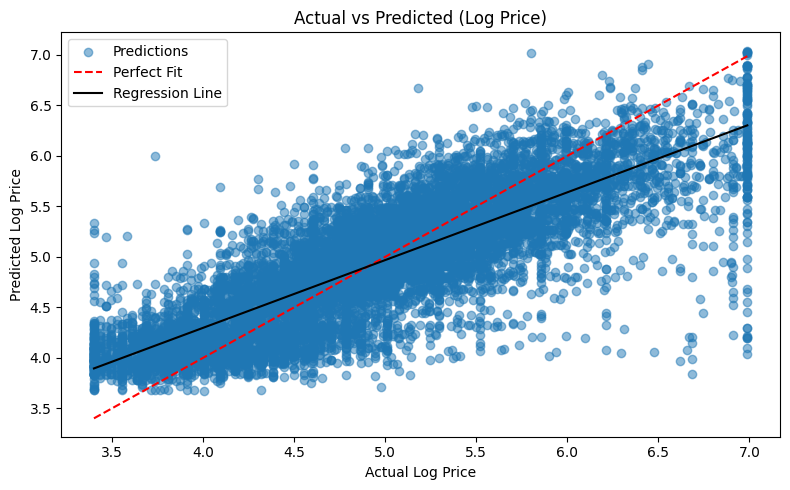

In [1185]:
# Fitting regression line to log values
model_line = LinearRegression()
model_line.fit(np.array(testY).reshape(-1, 1), predicted_log_prices)

# Regression line range
line_x = np.linspace(testY.min(), testY.max(), 100).reshape(-1, 1)
line_y = model_line.predict(line_x)

# Plotting the scatter grapgh with correlations
plt.figure(figsize=(8, 5))
plt.scatter(testY, predicted_log_prices, alpha=0.5, label='Predictions')
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], color='red', linestyle='dashed', label='Perfect Fit')
plt.plot(line_x, line_y, color='black', label='Regression Line')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Actual vs Predicted (Log Price)")
plt.legend()
plt.tight_layout()
plt.show()


Part 2

Part 2.1 K-mean clusters

In [1186]:
# Dropping columns that will not be used later on
drop_columns = [
    'name', 'description', 'host_id', 'host_since',
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
    'host_listings_count', 'host_total_listings_count',
    'accommodates_normalized', 'bedrooms_normalized', 'beds_normalized',
    'bathrooms_normalized', 'number_of_reviews_normalized',
    'review_scores_rating_normalized',
    'neighbourhood_original', 'property_type_original', 'original_room_type',
    'amenities'
]

df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns])


In [1187]:
# Selected features to use in models
neighbourhood_columns = [col for col in df_cleaned.columns if col.startswith('neighbourhood_')]
room_type_columns = [col for col in df_cleaned.columns if col.startswith('room_type_')]
selected_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'log_price', 'review_scores_rating'
]   + room_type_columns + neighbourhood_columns


# Building the dataset
df_selected = df_cleaned[selected_features].copy()

# Convert to numeric and handle missing values to use later
df_selected = df_selected.astype(float)
df_selected = df_selected.fillna(df_selected.mean())


In [1188]:
# Remove neighbourhoods to simplify dataframe
df_simple = df_selected.drop(columns=neighbourhood_columns)

# This ensures that all features contribute equally to the distance calculations in KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_simple)


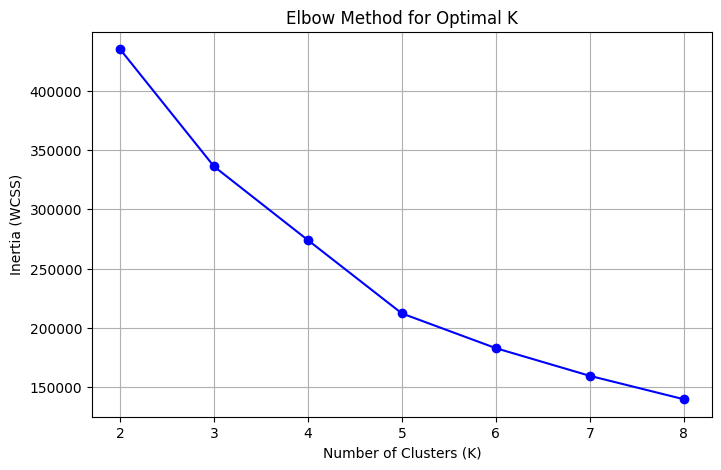

In [1189]:
# This creates the elbow chart to determine the most optimal k value
wcss = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


In [1190]:
# After using the chart we have gone with the value of 4 clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_simple['cluster'] = kmeans.fit_predict(X_scaled)


In [1191]:
#optimal_k = 4  # based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_selected['cluster'] = kmeans.fit_predict(X_scaled)

#Shows the size of each cluster
print(df_selected['cluster'].value_counts())


cluster
2    27990
0    19955
1    13137
3      282
Name: count, dtype: int64


In [1192]:
# Allows for visualizing complex clusters in a 2D scatter plot
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=['pca1', 'pca2'])
df_pca['cluster'] = df_simple['cluster'].values


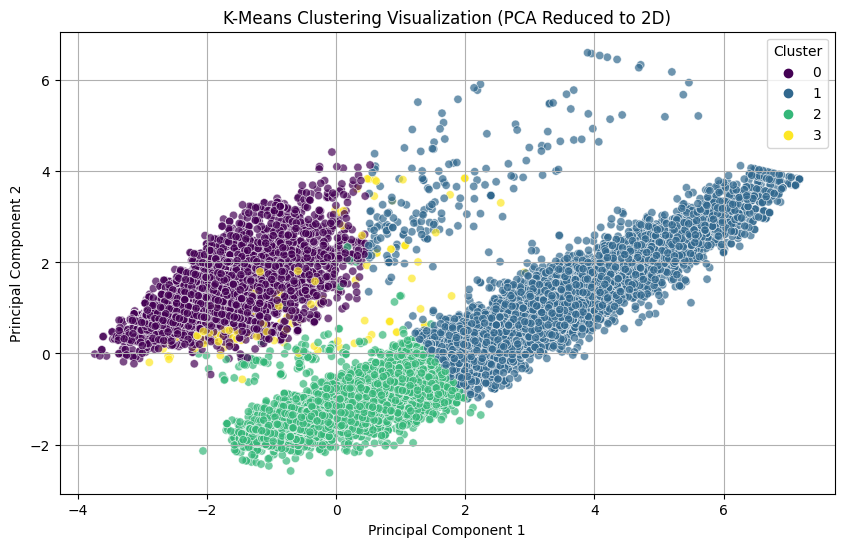

In [1193]:
# Plots the KMeans clustering results in 2D using PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='pca1', y='pca2', hue='cluster', palette='viridis', alpha=0.7)

plt.title("K-Means Clustering Visualization (PCA Reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [1205]:
# Select features (excluding log_price and cluster as they were )
X_global = df_selected.drop(columns=['log_price', 'cluster'])
y_global = df_selected['log_price']  # Target variable 

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_global, y_global, test_size=0.2, random_state=42)


In [1206]:
# Train the Linear Regression model
global_model = LinearRegression()
global_model.fit(X_train, y_train)

# Predict on test set
y_pred_global = global_model.predict(X_test)


In [1209]:
# Predict using the global model
y_pred_global = global_model.predict(X_test)

# Evaluate the model performance
mae_global = mean_absolute_error(y_test, y_pred_global)
mse_global = mean_squared_error(y_test, y_pred_global)
r2_global = r2_score(y_test, y_pred_global)

# Print the results
print(f"Global Regression Model")
print(f"R² Score: {r2_global:.2f}")
print(f"MAE: {mae_global:.2f}")
print(f"MSE: {mse_global:.4f}")


Global Regression Model
R² Score: 0.68
MAE: 0.33
MSE: 0.1931


In [1211]:
# Initialize dictionaries to store model performance for comparison
cluster_models = {}
cluster_mae = {}
cluster_mse = {}
cluster_r2 = {}

# Loop through each cluster and train a separate model
for cluster_id in df_selected['cluster'].unique():
    print(f"\nTraining for Cluster {cluster_id}...")

    # Filter data for this specific cluster
    cluster_data = df_selected[df_selected['cluster'] == cluster_id]
    X_cluster = cluster_data.drop(columns=['log_price', 'cluster'])
    y_cluster = cluster_data['log_price']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    # Train regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results in disctionaries
    cluster_models[cluster_id] = model
    cluster_mae[cluster_id] = mae
    cluster_mse[cluster_id] = mse
    cluster_r2[cluster_id] = r2

    # Print results
    print(f"Cluster performance")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")



Training for Cluster 3...
Cluster performance
R² Score: -0.1647
MAE: 0.7277
MSE: 0.9511

Training for Cluster 0...
Cluster performance
R² Score: 0.2969
MAE: 0.3297
MSE: 0.2094

Training for Cluster 2...
Cluster performance
R² Score: 0.3194
MAE: 0.2966
MSE: 0.1522

Training for Cluster 1...
Cluster performance
R² Score: 0.4166
MAE: 0.3307
MSE: 0.1787


In [1198]:
# Store regression results in a DataFrame including MSE
results_df = pd.DataFrame({
    "Cluster": list(cluster_mae.keys()),
    "MAE": list(cluster_mae.values()),
    "MSE": list(cluster_mse.values()),
    "R² Score": list(cluster_r2.values())
})

# Add the Global Model for comparison
results_df.loc[len(results_df)] = ['Global Model', mae_global, mse_global, r2_global]

# Display results
print(results_df)


        Cluster       MAE       MSE  R² Score
0             3  0.727711  0.951150 -0.164660
1             0  0.329750  0.209424  0.296938
2             2  0.296569  0.152188  0.319397
3             1  0.330733  0.178682  0.416645
4  Global Model  0.329432  0.193096  0.677911


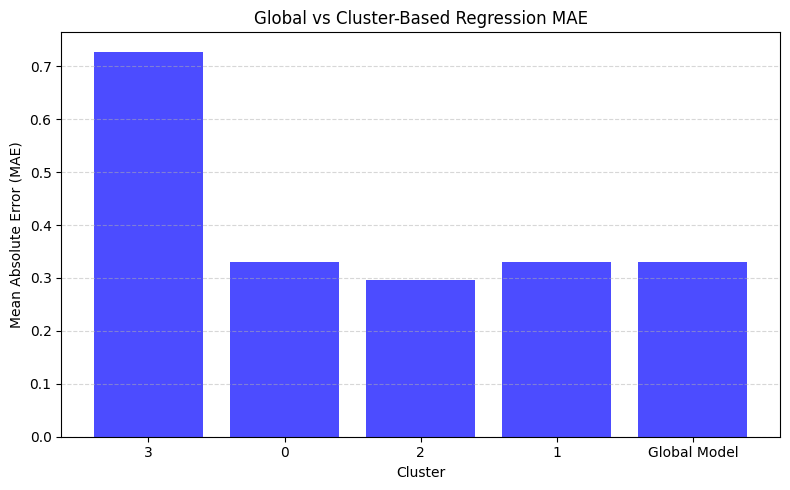

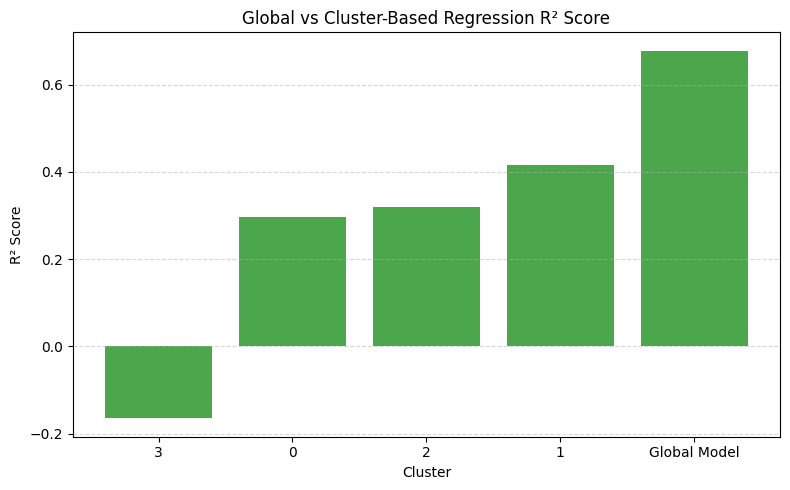

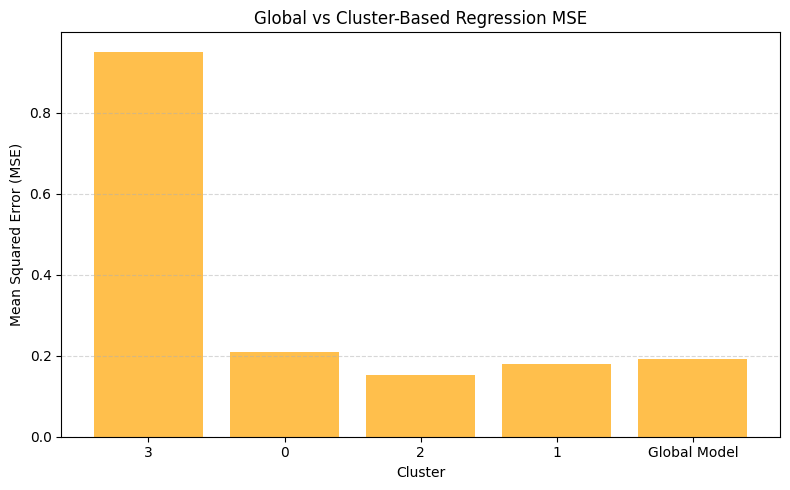

In [1199]:
# Visualisations created for comparison 

#MAE Chart 
plt.figure(figsize=(8, 5))
plt.bar(results_df["Cluster"].astype(str), results_df["MAE"], color='blue', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Global vs Cluster-Based Regression MAE")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#R² Score Chart
plt.figure(figsize=(8, 5))
plt.bar(results_df["Cluster"].astype(str), results_df["R² Score"], color='green', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("R² Score")
plt.title("Global vs Cluster-Based Regression R² Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# MSE Chart 
plt.figure(figsize=(8, 5))
plt.bar(results_df["Cluster"].astype(str), results_df["MSE"], color='orange', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Global vs Cluster-Based Regression MSE")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Improved model

In [1200]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select features and target variable 
X_rf = df_selected.drop(columns=['log_price', 'cluster']) 
y_rf = df_selected['log_price']  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Display dataset shape
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")


Training data shape: (49091, 42), Test data shape: (12273, 42)


In [1212]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score
import numpy as np

# Define and train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Cross-validation scores
cv_r2_scores = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv=5)
cv_mae_scores = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
cv_mse_scores = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# Cross-validated calculations
overall_r2_mean = np.mean(cv_r2_scores)
overall_r2_std = np.std(cv_r2_scores)
overall_mae_mean = np.mean(cv_mae_scores)
overall_mae_std = np.std(cv_mae_scores)
overall_mse_mean = np.mean(cv_mse_scores)
overall_mse_std = np.std(cv_mse_scores)

# Output XGBoost performance
print(f"XGBoost Results")
print(f"XGBoost R² Mean: {overall_r2_mean:.4f}")
print(f"XGBoost MAE Mean: {overall_mae_mean:.4f}")
print(f"XGBoost MSE Mean: {overall_mse_mean:.4f}")


XGBoost Results
XGBoost R² Mean: 0.4802
XGBoost MAE Mean: 0.3082
XGBoost MSE Mean: 0.1600


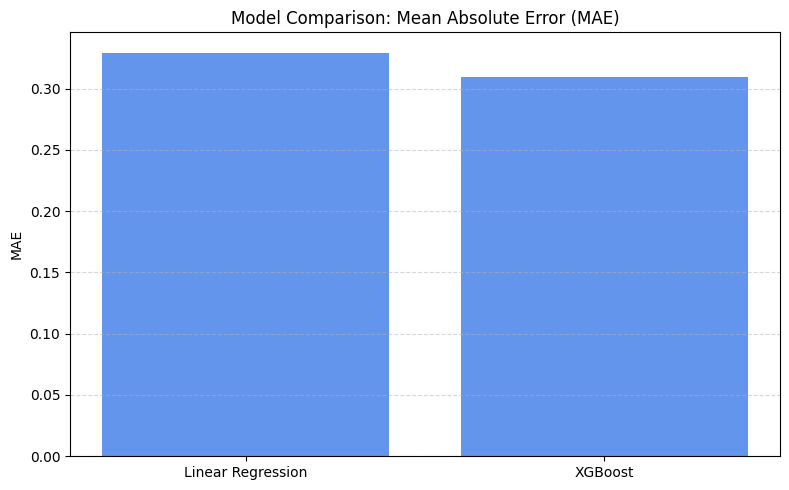

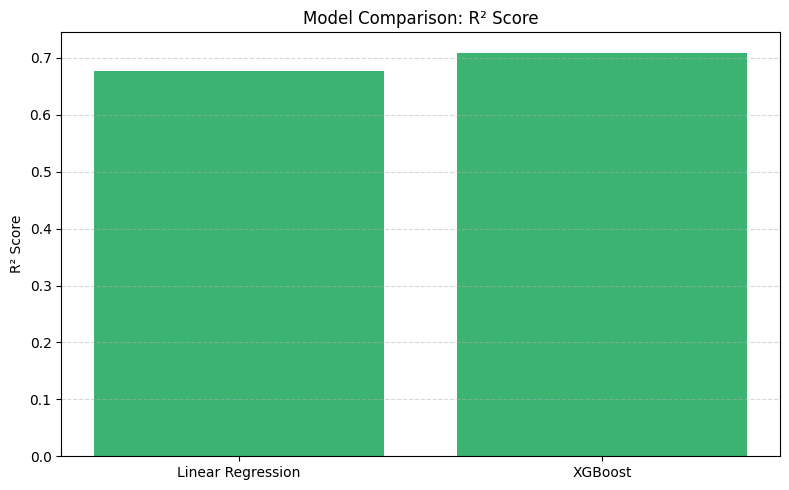

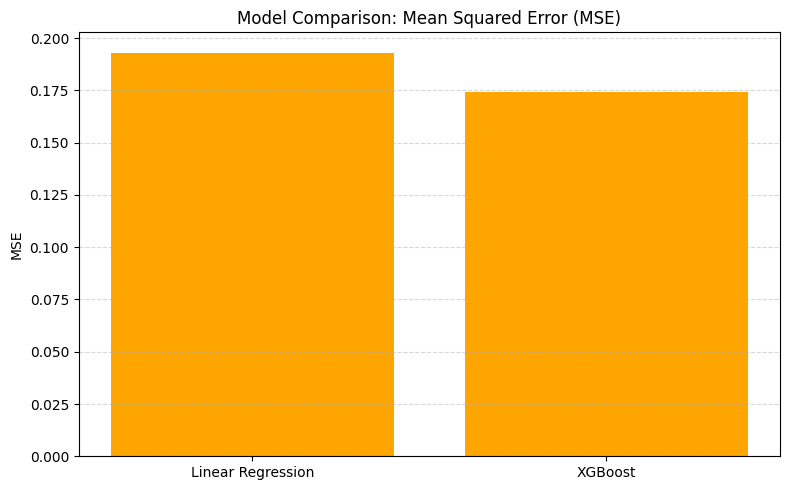

In [1202]:
import matplotlib.pyplot as plt
import pandas as pd

# Define model names and scores for comparison
model_names = ['Linear Regression', 'XGBoost']
mae_values = [mae_global, mae_xgb]
mse_values = [mse_global, mse_xgb]
r2_values = [r2_global, r2_xgb]

# Create comparison data
comparison_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_values,
    'R² Score': r2_values,
    'MSE': mse_values
})

# MAE Plot
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='cornflowerblue')
plt.title('Model Comparison: Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# R² Score Plot
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Model'], comparison_df['R² Score'], color='mediumseagreen')
plt.title('Model Comparison: R² Score')
plt.ylabel('R² Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# MSE Plot
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Model'], comparison_df['MSE'], color='orange')
plt.title('Model Comparison: Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [1213]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Define NN model with the layers
def create_model():
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train and evaluate on test set
model = create_model()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

y_pred_nn = model.predict(X_test).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = 1 - (mae_nn / np.mean(y_test))

print(f"NN Test results")
print(f"R²: {r2_nn*100:.2f}%")
print(f"MAE: {mae_nn:.4f}")
print(f"MSE: {mse_nn:.4f}")



Epoch 1/50
165/165 [==============================] - 0s 1ms/step - loss: 21.4219 - mae: 4.3287 - val_loss: 4.7980 - val_mae: 2.1255
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 3.3323 - mae: 1.4272 - val_loss: 0.3156 - val_mae: 0.4389
Epoch 3/50
165/165 [==============================] - 0s 1ms/step - loss: 2.0804 - mae: 1.1083 - val_loss: 0.3018 - val_mae: 0.4310
Epoch 4/50
165/165 [==============================] - 0s 1ms/step - loss: 1.6361 - mae: 0.9812 - val_loss: 0.2597 - val_mae: 0.3939
Epoch 5/50
165/165 [==============================] - 0s 1ms/step - loss: 1.3323 - mae: 0.8849 - val_loss: 0.2123 - val_mae: 0.3606
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 1.1381 - mae: 0.8220 - val_loss: 0.2184 - val_mae: 0.3616
Epoch 7/50
165/165 [==============================] - 0s 1ms/step - loss: 1.0036 - mae: 0.7704 - val_loss: 0.1942 - val_mae: 0.3411
Epoch 8/50
165/165 [==============================] - 0s 1ms/step - loss: 0

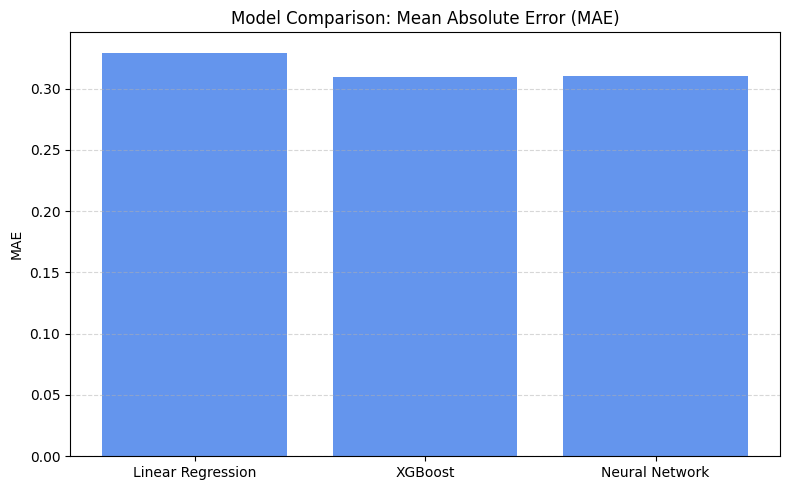

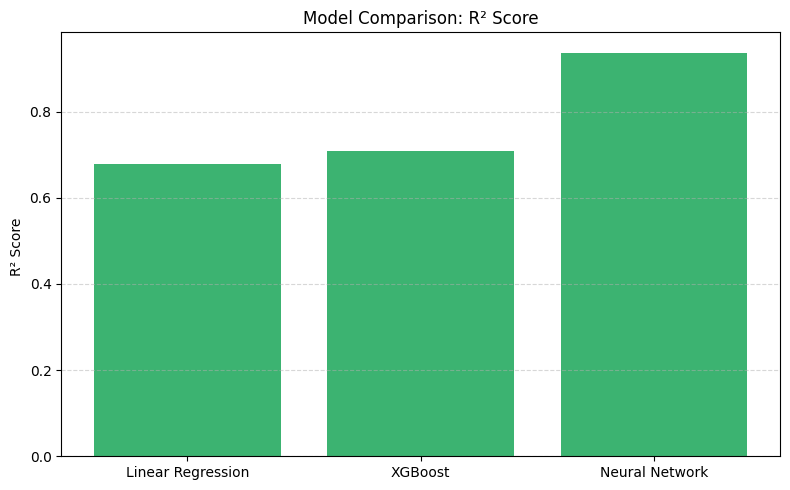

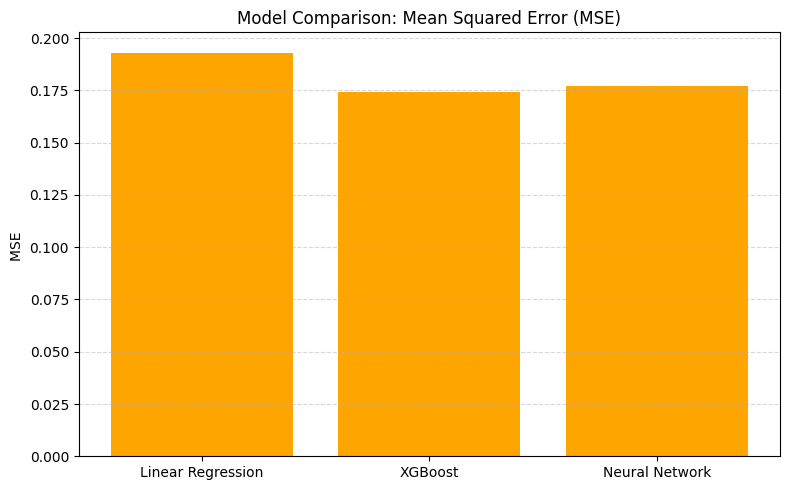

In [1204]:
# Define model names and metrics (replace these with your actual results if needed)
model_names = ['Linear Regression', 'XGBoost', 'Neural Network']
mae_values = [mae_global, mae_xgb, mae_nn]
mse_values = [mse_global, mse_xgb, mse_nn]
r2_values  = [r2_global, r2_xgb, r2_nn]

# Frame used for easy 
comparison_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_values,
    'MSE': mse_values,
    'R² Score': r2_values
})

# MAE Chart
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='cornflowerblue')
plt.title('Model Comparison: Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# R² Score Chart
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Model'], comparison_df['R² Score'], color='mediumseagreen')
plt.title('Model Comparison: R² Score')
plt.ylabel('R² Score ')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# MSE Chart
plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Model'], comparison_df['MSE'], color='orange')
plt.title('Model Comparison: Mean Squared Error (MSE)')
plt.ylabel('MSE ')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
